In [26]:
import numpy as np
import matplotlib.pyplot as plt
import data
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [27]:
HIDDEN_LAYER_DIM = 5
SEED = 103
NUM_EXAMPLES = 10
CLASSES = 3
DISTRIBUTIONS = 6
REG_LAMBDA = 1e-3

<h1> UTIL METHODS </h1>

In [28]:
def relu(entry):
    output = entry * (entry > 0)
    return np.array(output)


def softmax(z, entry):
    res = np.divide(z, entry)
    return res

def eval_perf(Y, Y_):
        # needed to compute scores of our model
        # 'weighted' takes into consideration labels imbalance
        if max(int(max(Y_) + 1), int(max(Y) + 1)) == 2:
            average = 'binary'
        else:
            average = 'weighted'

        accuracy = accuracy_score(Y_, Y)
        precision = precision_score(Y_, Y, average=average)
        recall = recall_score(Y_, Y, average=average)
        f1 = f1_score(Y_, Y, average=average)

        print("Accuracy: {0:.3f}\n"
              "Precision: {1:.3f}\n"
              "Recall: {2:.3f}\n"
              "F1: {3:.3f} ".format(accuracy, precision, recall, f1))

<h1> FCANN2 TRAIN </h1>

In [29]:
def fcann2_train(X, Y_, param_niter=1e5, param_delta=0.01):
    """
        Method that performs training part of a Fully Connected Artificial Neural Network
    :param X: dataset
    :param Y_: true classes
    :param param_niter: number of iterations
    :param param_delta: strength of update on each iteration
    :return:
    """
    D = X.shape[1]
    C = Y_.shape[1]
    N = X.shape[0]

    W1 = np.random.randn(D, HIDDEN_LAYER_DIM)
    b1 = np.random.randn(1, HIDDEN_LAYER_DIM)

    W2 = np.random.randn(HIDDEN_LAYER_DIM, C)
    b2 = np.random.randn(1, C)

    model = {}

    prev_loss = 9999

    for i in range(int(param_niter)+1):

        ###### HIDDEN LAYER PASS ######
        S1 = np.dot(X, W1) + b1
        H1 = relu(S1)
        S2 = np.dot(H1, W2) + b2

        ##### SOFTMAX PART #####
        exp_scores = np.exp(S2 - np.max(S2))
        sumexp = np.sum(exp_scores, axis=1, keepdims=True)
        probs = softmax(exp_scores, sumexp)

        ##### UPDATES WEIGHTS #####
        dS2 = (probs - Y_) / N

        dS1 = np.dot(dS2, W2.T)
        dS1[H1 <= 0] = 0  # reLU iz max(0, x), derivative is 0 if values are < 0

        dW2 = np.dot(H1.T, dS2)
        db2 = np.sum(dS2, axis=0, keepdims=True)

        dW1 = np.dot(X.T, dS1)
        db1 = np.sum(dS1, axis=0, keepdims=True)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += REG_LAMBDA * W2
        dW1 += REG_LAMBDA * W1

        # Gradient descent parameter update
        W1 += -param_delta * dW1
        b1 += -param_delta * db1
        W2 += -param_delta * dW2
        b2 += -param_delta * db2

        correct_class_prob = probs[range(len(X)), np.argmax(Y_, axis=1)]
        correct_class_logprobs = -np.log(correct_class_prob)  # N x 1
        loss = correct_class_logprobs.sum()

        if prev_loss > loss:
            # Assign new parameters to the model
            model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'best_iter': i}
            prev_loss = loss

        # dijagnostički ispis
        if i % 1000 == 0 and i != 0:
            print("iteration {}: loss {}".format(i, loss))

    return model

<h1> FCANN2 CLASSIFY</h1>

In [30]:
def fcann2_classify(model, X):
    """
        Method that performs classification based on trained NN model.
    :param model: Trained NN model given from fcann2_train method
    :param X: dataset
    :return: classifications for each sample in X
    """
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = X.dot(W1) + b1
    a1 = np.array(relu(z1))
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2 - np.max(z2))
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

<h1> DEMOS </h1>

<h3> USING 3 CLASSES </h3>

In [31]:
np.random.seed(SEED)

# get the training dataset
X, Y_ = data.sample_gmm_2d(DISTRIBUTIONS, CLASSES, NUM_EXAMPLES)

In [32]:
one_hot = Y_.reshape(-1)
one_hot = np.eye(CLASSES)[one_hot]

In [33]:
# train the model
model = fcann2_train(X, one_hot)
print ("Best weights at iteration:", model['best_iter'])

iteration 1000: loss 25.694269461293338
iteration 2000: loss 24.489741615175873
iteration 3000: loss 23.966704441454294
iteration 4000: loss 23.619893075233165
iteration 5000: loss 23.373974662628857
iteration 6000: loss 23.17246617679606
iteration 7000: loss 23.002362861685018
iteration 8000: loss 22.847531989565752
iteration 9000: loss 22.705736260135573
iteration 10000: loss 22.580979477547558
iteration 11000: loss 22.45630924236969
iteration 12000: loss 22.346660768169762
iteration 13000: loss 22.250732192151684
iteration 14000: loss 22.156839990925384
iteration 15000: loss 22.08415406978527
iteration 16000: loss 22.029379895734934
iteration 17000: loss 22.004871553074366
iteration 18000: loss 21.97080006889399
iteration 19000: loss 21.941688791399027
iteration 20000: loss 21.916557669325865
iteration 21000: loss 21.85973030349449
iteration 22000: loss 21.81948425890144
iteration 23000: loss 21.762336565310754
iteration 24000: loss 21.735395127767863
iteration 25000: loss 21.700843

In [34]:
Y = fcann2_classify(model, X)
print(Y)
print(Y_.flatten())

eval_perf(Y, Y_)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
Accuracy: 0.817
Precision: 0.873
Recall: 0.817
F1: 0.799 


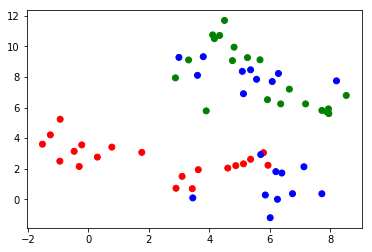

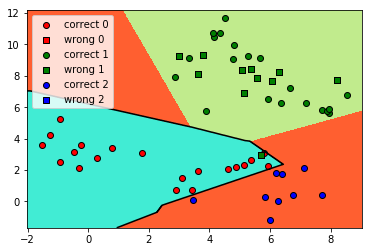

In [35]:
from matplotlib.colors import  ListedColormap

colors = ['red', 'green', 'blue']
plt.scatter(X[:, 0], X[:, 1], c=Y_.flatten(), cmap=ListedColormap(colors))
plt.show()

data.plot_decision_boundary(X, lambda x: fcann2_classify(model, x))

# graph the data points
data.graph_data(X, Y_, Y)

In [36]:
# more linearly splittable dataset
SEED2 = 118

In [37]:
np.random.seed(SEED2)

# get the training dataset
X2, Y_2 = data.sample_gmm_2d(DISTRIBUTIONS, CLASSES, NUM_EXAMPLES)

In [38]:
one_hot2 = Y_2.reshape(-1)
one_hot2 = np.eye(CLASSES)[one_hot2]

In [39]:
# train the model
model2 = fcann2_train(X2, one_hot2)
print ("Best weights at iteration:", model2['best_iter'])

iteration 1000: loss 14.30218617562223
iteration 2000: loss 11.924010737756664
iteration 3000: loss 10.700245022049655
iteration 4000: loss 9.892481848415278
iteration 5000: loss 9.302333865814095
iteration 6000: loss 8.850153984148614
iteration 7000: loss 8.493767734155155
iteration 8000: loss 8.206767604940099
iteration 9000: loss 7.973756202182352
iteration 10000: loss 7.780960406809802
iteration 11000: loss 7.6196311916282005
iteration 12000: loss 7.479831988495014
iteration 13000: loss 7.359355973592969
iteration 14000: loss 7.253235562700441
iteration 15000: loss 7.158439956107389
iteration 16000: loss 7.073175549411879
iteration 17000: loss 6.9958955340496045
iteration 18000: loss 6.924892133377466
iteration 19000: loss 6.859134573461904
iteration 20000: loss 6.798316861749361
iteration 21000: loss 6.7411109475201085
iteration 22000: loss 6.687473258872941
iteration 23000: loss 6.6367934347306905
iteration 24000: loss 6.58835008819328
iteration 25000: loss 6.542316647510082
iter

In [40]:
Y2 = fcann2_classify(model2, X2)
print(Y2)
print(Y_2.flatten())

eval_perf(Y2, Y_2)

[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2
 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Accuracy: 0.983
Precision: 0.984
Recall: 0.983
F1: 0.983 


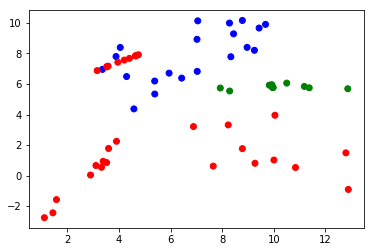

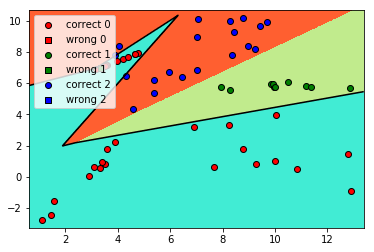

In [41]:
plt.scatter(X2[:, 0], X2[:, 1], c=Y_2.flatten(), cmap=ListedColormap(colors))
plt.show()

data.plot_decision_boundary(X2, lambda x: fcann2_classify(model2, x))

# graph the data points
data.graph_data(X2, Y_2, Y2)

<h3> USING ONLY 2 CLASSES </h3>

In [42]:
SEED3 = 100
NUM_EXAMPLES = 10
CLASSES = 2

In [43]:
np.random.seed(SEED3)

# get the training dataset
X3, Y_3 = data.sample_gmm_2d(DISTRIBUTIONS, CLASSES, NUM_EXAMPLES)

In [44]:
one_hot3 = Y_3.reshape(-1)
one_hot3 = np.eye(CLASSES)[one_hot3]

In [45]:
# train the model
model3 = fcann2_train(X3, one_hot3)
print ("Best weights at iteration:", model3['best_iter'])

iteration 1000: loss 37.622139154654654
iteration 2000: loss 37.45013916926295
iteration 3000: loss 37.409600976303246
iteration 4000: loss 37.36379001381855
iteration 5000: loss 37.31482986581079
iteration 6000: loss 37.26634858035894
iteration 7000: loss 37.215509156364426
iteration 8000: loss 37.16952630024465
iteration 9000: loss 37.12519665454229
iteration 10000: loss 37.0801239175828
iteration 11000: loss 37.03819322054927
iteration 12000: loss 36.97864064011344
iteration 13000: loss 36.917202011403255
iteration 14000: loss 36.85801748469629
iteration 15000: loss 36.78850737960406
iteration 16000: loss 36.7246273530009
iteration 17000: loss 36.65782559040713
iteration 18000: loss 36.59606706805458
iteration 19000: loss 36.53675033901045
iteration 20000: loss 36.46934231158611
iteration 21000: loss 36.41802848024003
iteration 22000: loss 36.35049301468477
iteration 23000: loss 36.298048800675645
iteration 24000: loss 36.25864933747253
iteration 25000: loss 36.20628529161306
iterat

In [46]:
Y3 = fcann2_classify(model3, X3)
print(Y3)
print(Y_3.flatten())

eval_perf(Y3, Y_3)

[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Accuracy: 0.667
Precision: 0.667
Recall: 0.667
F1: 0.667 


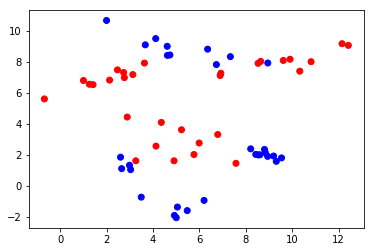

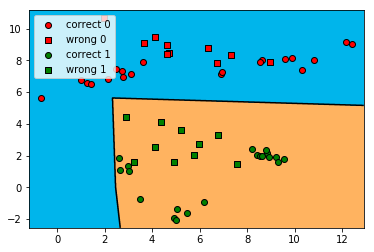

In [47]:
plt.scatter(X3[:, 0], X3[:, 1], c=Y_3.flatten(), cmap=ListedColormap(colors))
plt.show()

data.plot_decision_boundary(X3, lambda x: fcann2_classify(model3, x))

# graph the data points
data.graph_data(X3, Y_3, Y3)

In [48]:
SEED4 = 102
np.random.seed(SEED4)

# get the training dataset
X4, Y_4 = data.sample_gmm_2d(DISTRIBUTIONS, CLASSES, NUM_EXAMPLES)

one_hot4 = Y_4.reshape(-1)
one_hot4 = np.eye(CLASSES)[one_hot4]

# train the model
model4 = fcann2_train(X4, one_hot4)
print ("Best weights at iteration:", model4['best_iter'])

iteration 1000: loss 9.317624664278817
iteration 2000: loss 6.781553596186902
iteration 3000: loss 5.819711125681391
iteration 4000: loss 5.359555996062696
iteration 5000: loss 5.105432560473863
iteration 6000: loss 4.9517943535348445
iteration 7000: loss 4.853092434264569
iteration 8000: loss 4.786869809829303
iteration 9000: loss 4.740956128606477
iteration 10000: loss 4.708284843376698
iteration 11000: loss 4.684534575855935
iteration 12000: loss 4.6669544483039855
iteration 13000: loss 4.653736407841907
iteration 14000: loss 4.643660580036416
iteration 15000: loss 4.635885671539102
iteration 16000: loss 4.629820456647315
iteration 17000: loss 4.625042539431507
iteration 18000: loss 4.621240630244733
iteration 19000: loss 4.618196296726671
iteration 20000: loss 4.615742251051737
iteration 21000: loss 4.613752978194122
iteration 22000: loss 4.612132617211266
iteration 23000: loss 4.610807059816516
iteration 24000: loss 4.6097171418308545
iteration 25000: loss 4.60881827792633
iterati

In [49]:
Y4 = fcann2_classify(model4, X4)
print(Y4)
print(Y_4.flatten())

eval_perf(Y4, Y_4)

[1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Accuracy: 0.967
Precision: 0.950
Recall: 0.950
F1: 0.950 


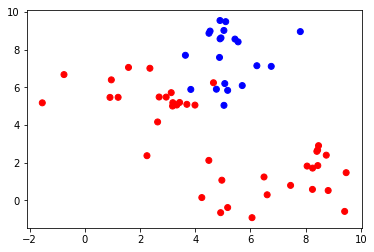

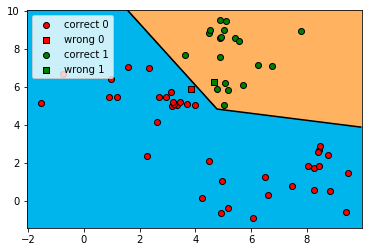

In [50]:
plt.scatter(X4[:, 0], X4[:, 1], c=Y_4.flatten(), cmap=ListedColormap(colors))
plt.show()

data.plot_decision_boundary(X4, lambda x: fcann2_classify(model4, x))

# graph the data points
data.graph_data(X4, Y_4, Y4)